In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from torchvision import models
from torchvision.utils import make_grid

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [4]:
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [5]:
root = '/content/drive/MyDrive/ineuron_opencv/cat & dog/CATS_DOGS'
train_data = datasets.ImageFolder(os.path.join(root,'train'),transform = train_transforms)

test_data = datasets.ImageFolder(os.path.join(root,'test'),transform = test_transforms)

torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

class_names = train_data.classes


In [6]:
class_names

['CAT', 'DOG']

In [7]:
len(train_data)

18780

In [8]:
len(test_data)

6283

In [9]:
for images, labels in train_loader:
  break

In [10]:
images.shape

torch.Size([10, 3, 224, 224])

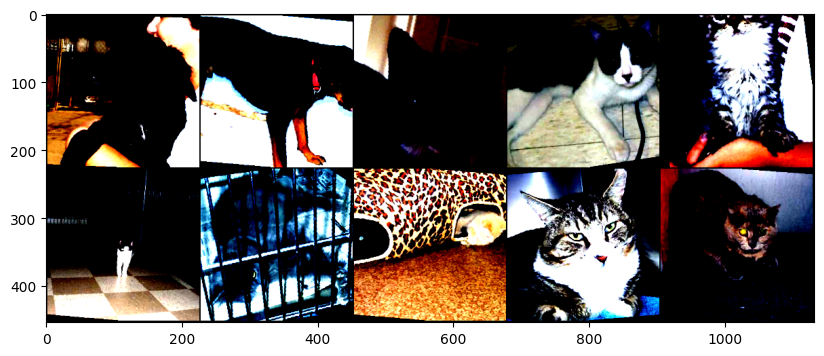

In [11]:
im = make_grid(images,nrow=5)
plt.figure(figsize=(12,4))

plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [12]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    self.fc1 = nn.Linear(54*54*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,2)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1,54*54*16)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X,dim=1)

In [13]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(),lr=0.001)

In [14]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [15]:
for p in CNNmodel.parameters():
  print(p.numel())

162
6
864
16
5598720
120
10080
84
168
2


In [ ]:
import time
start_time = time.time()

epochs = 3
#Limits on no. of batches
max_trn_batch = 800  # each batch = 10 imges, total = 8000
max_tst_batch = 300  #total 3000

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):

  trn_corr = 0
  tst_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):

    #optional Limit no of batches

    if b == max_trn_batch:
      break

    b+=1

    y_pred = CNNmodel(X_train)
    loss = criterion(y_pred,y_train)

    #tally no of correct predictions
    predicted = torch.max(y_pred.data,1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    #updating the parameters

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if b%200==0:
      print(f'Epoch {i} LOSS:{loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)


    #test set
    with torch.no_grad():
      for b, (X_test,y_test) in enumerate(test_loader):

        #optional
        if b==max_tst_batch:
          break

        y_val = CNNmodel(X_test)

        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        tst_corr = tst_corr + batch_corr

    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)





total_time = time.time() - start_time
print(f'Total Time : {total_time/60} minutes')